In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import matplotlib.image as mpimg

# Read Data Set

In [2]:
segmentations = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
segmentations['EncodedPixels'] = segmentations['EncodedPixels'].astype('string')

# Description of features

 **EncodedPixels** - a list of pixels for ship segmentation in a compressed format. 
 
 EncodedPixels сonsists of pairs of values that contain a start position and a run length. 
 E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).
 
 The pixels are one-indexed and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc. 
 
 A prediction of of "no ship in image" have a blank value in the EncodedPixels column.
 

# Feature Extraction

Let's add new features:
* **ImageHeight** - image height
* **ImageWidth** - image weight
* **ShipAreaPercentage** - percentage of the ship segmentation area in the image. Measured as a percentage, from 0 to 100%

In [3]:
def get_image(name: str):
    path = f'/kaggle/input/airbus-ship-detection/train_v2/{name}'
    return cv2.imread(path)

def extract_features_from_image(row: pd.Series) -> pd.Series:
    image = get_image(row['ImageId'])
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row

segmentations = segmentations.apply(lambda x: extract_features_from_image(x), axis=1)

Premature end of JPEG file


In [4]:
def pixels_number(encoded_pixels: str) -> int:
    if pd.isna(encoded_pixels):
        return 0
    return np.array(encoded_pixels.split()[1::2], dtype=int).sum()

segmentations['ShipAreaPercentage'] = segmentations.apply(lambda x: pixels_number(x['EncodedPixels']) / (x['ImageHeight'] * x['ImageWidth']) * 100, axis=1)

# Exploring the data

In [5]:
print(f'There are {segmentations.shape[0]} images.')
segmentations.head(10)

There are 231723 images.


,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage
0,00003e153.jpg,<NA>,768,768,0.000000
1,0001124c7.jpg,<NA>,768,768,0.000000
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768,768,0.574409
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768,768,0.030009
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,768,768,0.025092
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,768,768,0.081380
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,768,768,0.001187
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,768,768,0.109863
8,0001b1832.jpg,<NA>,768,768,0.000000
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,768,768,0.067817


## Image resolution

In [6]:
print(segmentations['ImageHeight'].value_counts())
print(segmentations['ImageWidth'].value_counts())

768    231723
Name: ImageHeight, dtype: int64
768    231723
Name: ImageWidth, dtype: int64


All images have the same resolution 768 * 768 * 3.

## Distribution of the number of ships in images

In [7]:
images_without_ships = segmentations['EncodedPixels'].isna().sum()
print(f'There are {images_without_ships} images without ships.')

There are 150000 images without ships.


ShipCount
0            150000
1             27104
2              7674
3              2954
4              1622
5               925
6               657
7               406
8               318
9               243
10              168
11              144
12              124
14               76
13               75
15               66
dtype: int64


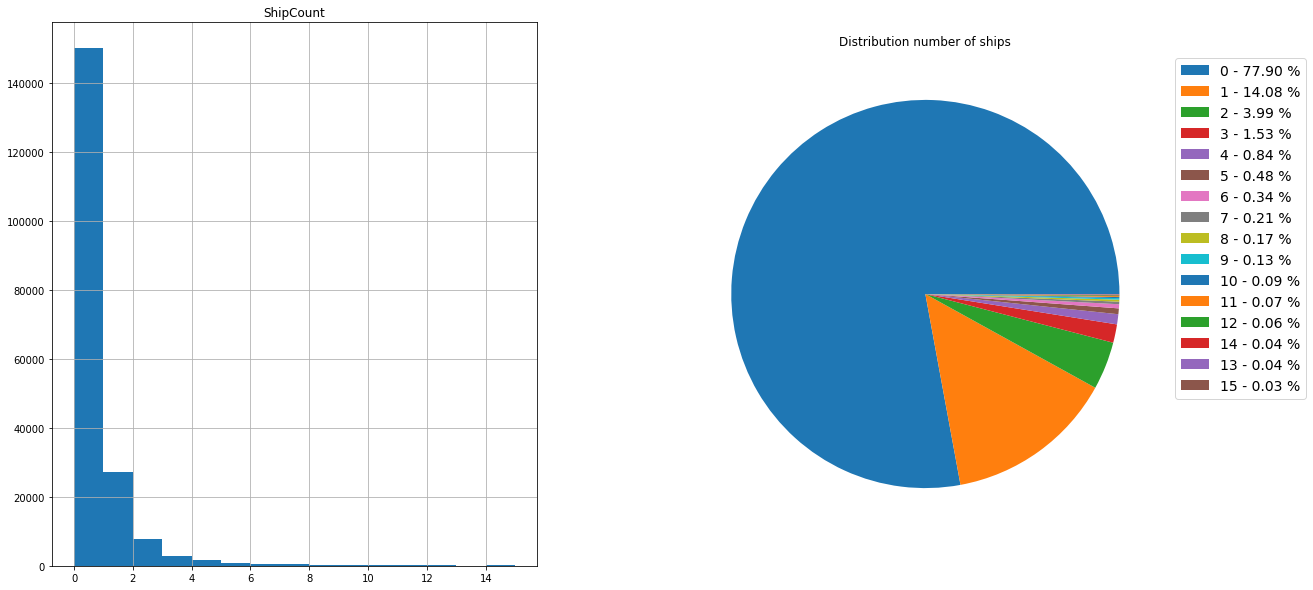

In [8]:
segmentations['ShipCount'] = segmentations.apply(lambda x: 0 if pd.isna(x['EncodedPixels']) else 1, axis=1)
ships_numbers = segmentations[['ImageId','ShipCount']].groupby(['ImageId']).sum()
print(ships_numbers.value_counts())

f,ax=plt.subplots(1, 2,figsize=(20,10))

ships_numbers.hist(bins = 15, ax=ax[0])

y = ships_numbers.value_counts().values
percent = 100.*y/y.sum()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(ships_numbers.value_counts().index.get_level_values(0), percent)]
ships_numbers.value_counts().plot.pie(labels=None, ax=ax[1])
ax[1].legend(labels, bbox_to_anchor=(1., 1.), fontsize=14)
ax[1].yaxis.set_visible(False)
ax[1].set_title('Distribution number of ships')

plt.show()

We can see that 78% of images don't have any ships. Only 14% have one ship. And on the remaining 8% of the images there are from 2 to 15 ships.

## Ship segmentation area distribution

Text(0.5, 0, '')

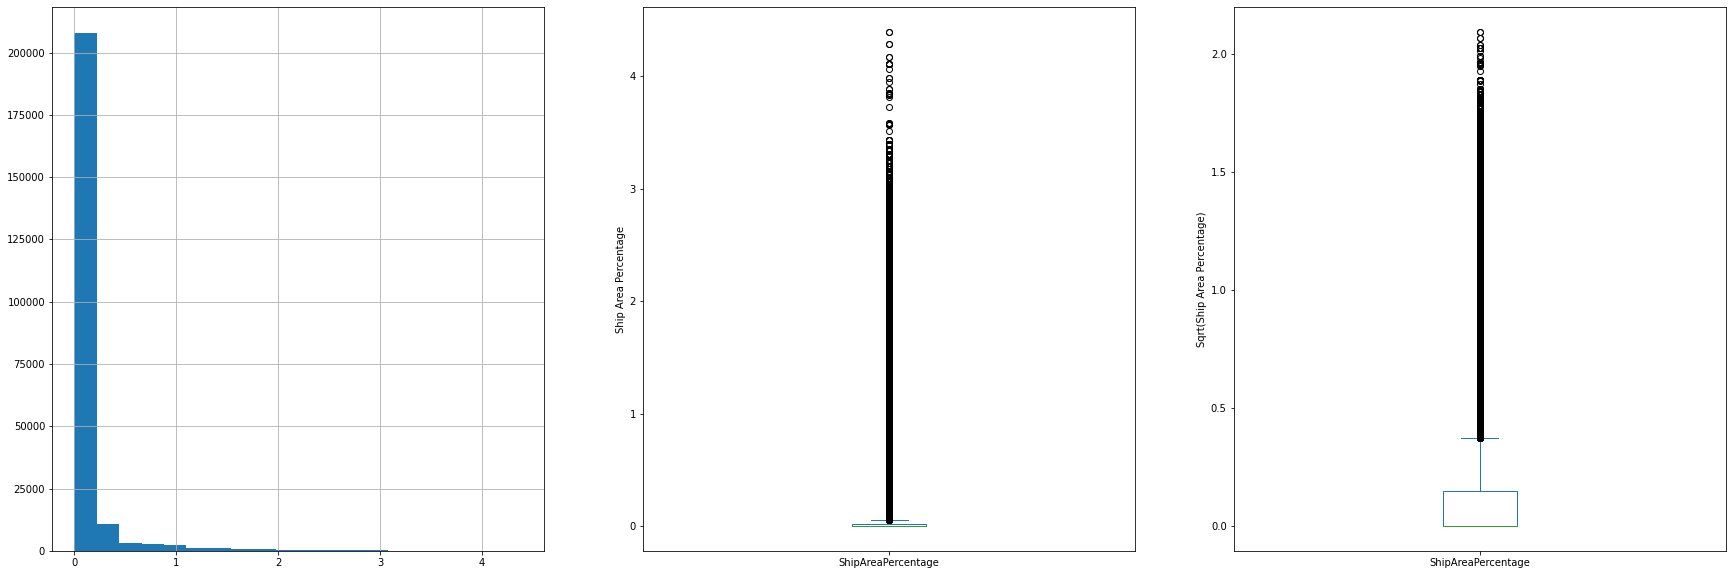

In [64]:
f,ax=plt.subplots(1, 3,figsize=(30,10))

segmentations['ShipAreaPercentage'].hist(bins=20, ax=ax[0])
segmentations['ShipAreaPercentage'].plot.box(ax=ax[1])
ax[1].set_ylabel('Ship Area Percentage')
ax[1].set_xlabel('')
segmentations['ShipAreaPercentage'].apply(lambda x: x ** 0.5).plot.box(ax=ax[2])
ax[2].set_ylabel('Sqrt(Ship Area Percentage)')
ax[2].set_xlabel('')

All ships are very small in the images. Ships occupy no more than 4% of the image. Most of the ships take up less than 0.1% of the image.

# Display ship segmentation pixels

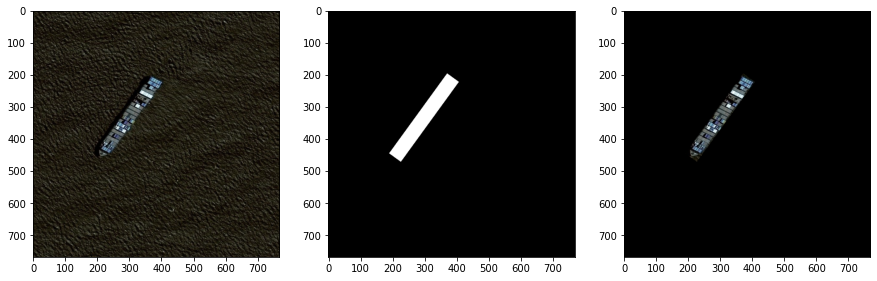

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage,ShipCount
32,0006c52e8.jpg,146366 1 147132 4 147899 5 148666 7 149432 10 ...,768,768,2.355448,1


In [69]:
def show_image_with_encoded_pixels(image_id: str):
    rows = segmentations[segmentations['ImageId'] == image_id]
    if len(rows) == 0:
        return
    
    image_info = rows.iloc[0]
    image = get_image(image_id)
    image_size, _, _ = image.shape
    
    encoded_pixels = np.array(image_info['EncodedPixels'].split(), dtype=int)
    pixels, shift = encoded_pixels[::2], encoded_pixels[1::2]
    ship = np.zeros_like(image)

    for pixel, shift in zip(pixels, shift):
        for i in range(shift):
            cur_pixel = pixel + i - 1
            ship[cur_pixel % image_size, cur_pixel // image_size] = [255, 255, 255]

    f,ax=plt.subplots(1, 3,figsize=(15,5))
    ax[0].imshow(image)
    ax[1].imshow(ship)
    ax[2].imshow(image * (ship // 255))
    plt.show()

show_image_with_encoded_pixels('0006c52e8.jpg')
segmentations[segmentations['ImageId'] == '0006c52e8.jpg']